# <center> Drug Review Analysis </center>

## About the Notebook

The notebook was created to analyse the drug review dataset from kaggle.

## The Dataset Description

We downloaded our Drug Review Dataset dataset from Kaggle, but originally it was taken from the UCI Machine Learning Repository. The data was obtained by crawling online pharmaceutical review sites. This Dataset provides patient reviews on 3671 differents drugs for specific conditions. Along with the review, the patiemt also rate the madication with a numeric rating from 1 to 10. Here are the features :

UniqueID : Unique ID for each record. There are a total of 215,063 unique IDs in the dataset. 

DrugName: The name of the specific dru. There are total 3671 unique drugs in the dataset.

Condition: The medical condition of the user under which the drug has been consumed. There are a total of 917 unique conditions.

Review: Review written by the users of the drugs used for a specified condition. There are a total of 128478 distinct reviews.

Rating: The rating given by the customer from 1 to 10 to a drug for a condition.

Date: Date on which the review has been entered. Date range is 02/24/2008-12/11/2017.

UsefulCount:  It is the number of people who found the rating and review of a customer relevant and helpful. The range of useful count is 0-1291.


## Libraries Used 

In [128]:
import pandas as pd
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem.porter import *
import numpy as np
from matplotlib import pyplot
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import nltk
import nltk.corpus
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
from scipy import stats

from sklearn import model_selection
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


## Set Up Pandas Options

In [2]:
Setting Display option for rows & columns
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)
pd.set_option('display.min_rows', 5)
#pd.set_option('display.expand_frame_repr', True)

## Loading the Data

In [3]:
data_train = pd.read_csv("drugreview/drugscomtrain_raw.csv", index_col = "uniqueID") #, low_memory=False, nrows=100
len(data_train)

161297

In [4]:
data_test = pd.read_csv("drugreview/drugscomtest_raw.csv", index_col = "uniqueID") #, low_memory=False, nrows=100
len(data_test)

53766

In [5]:
data = pd.concat([data_train, data_test])

In [6]:
data

,drugName,condition,review,rating,date,usefulCount
uniqueID,,,,,,
206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
...,...,...,...,...,...,...
159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10,13-Sep-14,43
140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9,8-Oct-16,11
130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8,15-Nov-10,7


In [7]:
data[data[["drugName","condition", "review","rating", "usefulCount"]].duplicated()]

,drugName,condition,review,rating,date,usefulCount
uniqueID,,,,,,
166567,Levonorgestrel,Emergency Contraception,"""I had a quickie n he decided to finish it off...",1,23-Sep-16,10
67838,Plan B,Emergency Contraception,"""I had a quickie n he decided to finish it off...",1,23-Sep-16,10


In [8]:
# in case we want to upload a sample
# data= data.sample(frac=0.2)

In [9]:
len(data)

215063

## Descriptive Statistics

In [10]:
data.describe()

,rating,usefulCount
count,215063.000000,215063.000000
mean,6.990008,28.001004
std,3.275554,36.346069
min,1.000000,0.000000
25%,5.000000,6.000000
50%,8.000000,16.000000
75%,10.000000,36.000000
max,10.000000,1291.000000


In [11]:
def describe_cat(data):
    table=pd.DataFrame(columns = data.select_dtypes("object").columns, index = ["count", "nulls","%miss", 'cardinality', "mode", "mode freq", "mode%", "2nd mode", "2nd mode freq", "2nd mode%"])
    for col in data.select_dtypes("object").columns :
        table.loc["count"][col] = len(data[col])
        table.loc["nulls"][col] = len(data[data[col].isna() == True][col])
        table.loc["%miss"][col] = table.loc["nulls"][col]/table.loc["count"][col]
        table.loc["cardinality"][col]= len(data[col].unique())
        table.loc["mode"][col]= data[col].value_counts().index[0]
        table.loc["mode freq"][col]= data[col].value_counts()[0]
        table.loc["mode%"][col]= table.loc["mode freq"][col]/table.loc["count"][col]
        if table.loc["cardinality"][col] != table.loc["mode freq"][col]:
            table.loc["2nd mode"][col]= data[col].value_counts().index[1]
            table.loc["2nd mode freq"][col]= data[col].value_counts()[1]
            table.loc["2nd mode%"][col]= table.loc["2nd mode freq"][col]/table.loc["count"][col]    
    return table

In [12]:
describe_cat(data)

,drugName,condition,review,date
count,215063,215063,215063,215063
nulls,0,1194,0,0
%miss,0.0,0.005552,0.0,0.0
cardinality,3671,917,128478,3579
mode,Levonorgestrel,Birth Control,"""Good""",1-Mar-16
mode freq,4930,38436,39,185
mode%,0.022924,0.17872,0.000181,0.00086
2nd mode,Etonogestrel,Depression,"""Good.""",31-Mar-16
2nd mode freq,4421,12164,26,183
2nd mode%,0.020557,0.05656,0.000121,0.000851


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 206461 to 113712
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   drugName     215063 non-null  object
 1   condition    213869 non-null  object
 2   review       215063 non-null  object
 3   rating       215063 non-null  int64 
 4   date         215063 non-null  object
 5   usefulCount  215063 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 11.5+ MB


In [14]:
# checking if the data contains NULL values
data.isnull().any()

drugName       False
condition       True
review         False
rating         False
date           False
usefulCount    False
dtype: bool

In [15]:
print(len(data.drugName.unique()))

3671


In [16]:
print(len(data.condition.unique()))

917


### Disctributions

array([[<AxesSubplot:title={'center':'rating'}>,
        <AxesSubplot:title={'center':'usefulCount'}>]], dtype=object)

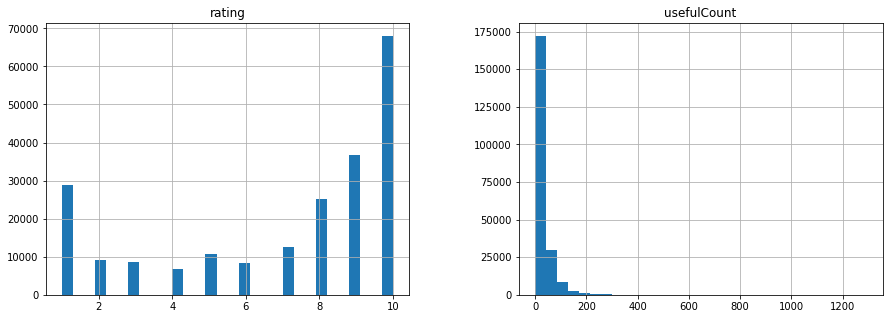

In [17]:
data.hist(bins=30, figsize=(15, 5))

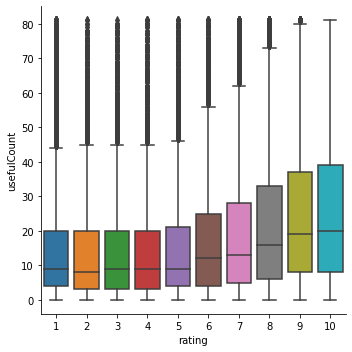

In [23]:
newdata = data.drop(data[data['usefulCount'] > 81].index)
sns.catplot(x="rating", y="usefulCount", kind="box", data=newdata)

In [26]:
data.groupby(by = "rating").count()["review"]

rating
1     28918
2      9265
3      8718
4      6671
5     10723
6      8462
7     12547
8     25046
9     36708
10    68005
Name: review, dtype: int64

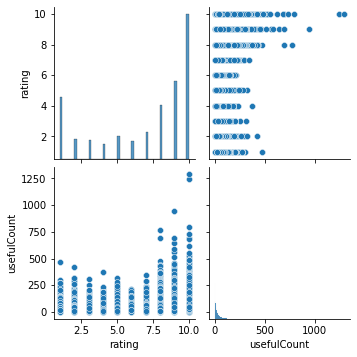

In [19]:
sns.pairplot(data)
plt.show()

### Outliers

In [20]:
# Finding Threshholds from each numeric feature
def find_thresholds (data):   
    table=pd.DataFrame(columns = data.select_dtypes(include=['int64','float64']).columns, index = ["Q1", "Q3","IQR", 'min', "max", "lower treshold", "upper treshold"])
    for col in data.select_dtypes(include=['int64','float64']).columns :
        Q1 = data[col].quantile(q=0.25)
        Q3 = data[col].quantile(q=0.75)
        IQR = Q3-Q1
        table.loc["Q1"][col] = Q1
        table.loc["Q3"][col] = Q3
        table.loc["IQR"][col] = IQR
        table.loc['min'][col]= data[col].min()
        table.loc["max"][col]= data[col].max()
        table.loc["lower treshold"][col]= Q1-(1.5)*IQR
        table.loc["upper treshold"][col]= Q3+(1.5)*IQR
    return table

In [21]:
threshholds = find_thresholds(data)

In [22]:
threshholds

,rating,usefulCount
Q1,5.0,6.0
Q3,10.0,36.0
IQR,5.0,30.0
min,1,0
max,10,1291
lower treshold,-2.5,-39.0
upper treshold,17.5,81.0


In [27]:
data[data["usefulCount"]<100]

,drugName,condition,review,rating,date,usefulCount
uniqueID,,,,,,
206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43
...,...,...,...,...,...,...
159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10,13-Sep-14,43
140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9,8-Oct-16,11
130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8,15-Nov-10,7


In [163]:
len(data[data["usefulCount"]<200])/ len(data)

0.9999298101129589

### Meaningless Values and Characters

In [25]:
data[data["condition"].str.contains("users found this comment helpful.")==True]

,drugName,condition,review,rating,date,usefulCount
uniqueID,,,,,,
220696,Loestrin 24 Fe,2</span> users found this comment helpful.,"""I&#039;m 16 and I have been on Loestrin 24 f...",3,3-Nov-10,2
67383,Provera,4</span> users found this comment helpful.,"""I&#039;m 24 years old and have always had a p...",1,27-Mar-16,4
81588,Yaz,3</span> users found this comment helpful.,"""I took Yaz for a little over 2 years. From a...",3,1-Jun-10,3
132965,Loestrin 24 Fe,4</span> users found this comment helpful.,"""Took this pill for 1.) Acne and 2.) Birth Con...",2,24-Jun-14,4
91050,Norco,11</span> users found this comment helpful.,"""I have suffered with low back pain - 2 surger...",9,15-Mar-09,11
...,...,...,...,...,...,...
133354,Tri-Sprintec,3</span> users found this comment helpful.,"""I have been taking this pill for less than a ...",8,24-Sep-10,3
149494,Mirena,5</span> users found this comment helpful.,"""I got the Mirena put in last month. And holy ...",7,12-Feb-13,5
91988,Lyrica,21</span> users found this comment helpful.,"""It was a nightmare.I had the worse side effec...",1,14-Apr-15,21


In [34]:
# Before replacing the symbol &#039;
data[data["review"].str.contains("&#039;")==True]

,drugName,condition,review,rating,date,usefulCount
uniqueID,,,,,,
92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43
165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,7-Mar-17,5
...,...,...,...,...,...,...
35261,Levofloxacin,Bronchitis,"""This is my 3rd time taking this medicine. Fir...",10,26-Oct-14,29
33495,Microgestin Fe 1 / 20,Birth Control,"""I was on Microgestin for about 3 years. Over ...",6,1-Aug-14,15
123432,Apri,Birth Control,"""I started taking Apri about 7 months ago. My ...",9,25-Aug-10,18


## Cleaning Data

### Replace rows with "users found this comment helpful." with null to be treated later

In [29]:
data[data["condition"].str.contains("users found this comment helpful.")==True]

,drugName,condition,review,rating,date,usefulCount
uniqueID,,,,,,
220696,Loestrin 24 Fe,2</span> users found this comment helpful.,"""I&#039;m 16 and I have been on Loestrin 24 f...",3,3-Nov-10,2
67383,Provera,4</span> users found this comment helpful.,"""I&#039;m 24 years old and have always had a p...",1,27-Mar-16,4
81588,Yaz,3</span> users found this comment helpful.,"""I took Yaz for a little over 2 years. From a...",3,1-Jun-10,3
132965,Loestrin 24 Fe,4</span> users found this comment helpful.,"""Took this pill for 1.) Acne and 2.) Birth Con...",2,24-Jun-14,4
91050,Norco,11</span> users found this comment helpful.,"""I have suffered with low back pain - 2 surger...",9,15-Mar-09,11
...,...,...,...,...,...,...
133354,Tri-Sprintec,3</span> users found this comment helpful.,"""I have been taking this pill for less than a ...",8,24-Sep-10,3
149494,Mirena,5</span> users found this comment helpful.,"""I got the Mirena put in last month. And holy ...",7,12-Feb-13,5
91988,Lyrica,21</span> users found this comment helpful.,"""It was a nightmare.I had the worse side effec...",1,14-Apr-15,21


In [30]:
data["condition"] = np.where(data["condition"].str.contains("users found this comment helpful.")==True, np.NaN, data["condition"])


In [31]:
## data = data.drop(data[data["condition"].str.contains("users found this comment helpful.")==True].index)

In [32]:
data[data["condition"].str.contains("users found this comment helpful.")==True]

,drugName,condition,review,rating,date,usefulCount
uniqueID,,,,,,


### Fill up null values in condition column

In [33]:
for medic in data[data["condition"].isna()].drugName.unique():
    if len(data[(data["drugName"]==medic)].condition.mode())>0 :
        frequent = data[(data["drugName"]==medic)].condition.mode()[0]
        data.loc[(data["condition"].isna()) & (data["drugName"] == medic), ["condition"]] = frequent   

### Replace symbols with correpondant character

In [35]:
def replace_char(column, character, replacement):
    for i, row in data.iterrows():
        newvalue = row[column]
        newvalue = newvalue.replace(character,replacement)
        data.loc[i,column] = newvalue 

In [36]:
replace_char("review","&#039;","'")

In [38]:
replace_char("review","&amp;","and")

In [39]:
replace_char("review","&quot;",'"')

In [40]:
replace_char("review","&rsquo;","'")

In [41]:
replace_char("review","&ldquo;",'"')

In [42]:
replace_char("review","&rdquo;",'"')

In [43]:
replace_char("review","&lrm;",'')

In [44]:
replace_char("review","&gt;",'>')

In [45]:
replace_char("review","&pound;",'£')

In [46]:
replace_char("review","&lsquo;","'")

In [47]:
replace_char("review","&ntilde;","n")

In [48]:
replace_char("review","&mdash;","-")

In [49]:
replace_char("review","&hellip;","...")

In [50]:
replace_char("review","&eacute;","é")

In [51]:
replace_char("review","&lt;","<")

In [52]:
replace_char("review","&deg;"," degrees")

### Drop any remainting row with special characters

In [53]:
data[data["review"].str.contains("&")==True]

,drugName,condition,review,rating,date,usefulCount
uniqueID,,,,,,
207231,Valtrex,"Herpes Simplex, Suppression","""I found out I had genital hsv 1 about a month...",9,3-Sep-16,17
115035,Diazepam,Anxiety,"""After taking Chantix for smoking cessation I ...",9,1-Aug-15,68
153782,Amoxicillin,Urinary Tract Infection,"""Only used this to cure my UTI so it wouldn't ...",1,23-Nov-16,28
163096,ella,Emergency Contraception,"""Hey,\r\r\nSo I took the ellaOne about 7h afte...",9,13-Sep-16,10
216569,Sucralfate,GERD,"""I have been diagnosed with extreme acid reflu...",2,7-Mar-17,12
...,...,...,...,...,...,...
159098,TriNessa,Birth Control,"""I'm 19 and this is my first birth control pil...",8,12-Jan-17,11
214045,Tioconazole,Vaginal Yeast Infection,"""It has been 3 years since I tried this produc...",1,2-Jul-16,13
93922,Trintellix,Major Depressive Disorde,"""I have dealt with chronic depression most of ...",10,6-May-17,46


In [54]:
data.drop(data[data["review"].str.contains("&")==True].index, inplace = True)

In [55]:
#from nltk.probability import FreqDist
#fdist = FreqDist(words)
# To find the frequency of top 10 words
#fdist1 = fdist.most_common(100)
#fdist1

### Remove outliers

In [56]:
data.drop(data[data["usefulCount"]>200].index, inplace = True)

In [57]:
data.to_csv("CleanData.csv")

## Data Preparation for setiment analysis

### Cleaning and stemming reviews

In [59]:
def remove_stop_words_punc (text, stop_words):
    #words= text.split
    #token = word_tokenize(text)
    list_words = [w for w in word_tokenize(text) if not w in stop_words]
    recons_text = " ".join(list_words)
    recons_text = recons_text.translate(str.maketrans("","", string.punctuation))
    recons_text = "".join([i for i in recons_text if not i.isdigit()])
    while "  " in recons_text :
        recons_text = recons_text.replace("  ", " ")
    return recons_text


In [60]:
def stemming(sentence):
    porter=PorterStemmer()
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [61]:
stop_words = set(stopwords.words('english'))
for i, row in data.iterrows():
    newvalue = row["review"]
    newvalue = stemming(remove_stop_words_punc(newvalue, stop_words))
    data.loc[i,"review"] = newvalue

## Exploratory Data Analysis

### Distribution After cleaning 

array([[<AxesSubplot:title={'center':'rating'}>,
        <AxesSubplot:title={'center':'usefulCount'}>]], dtype=object)

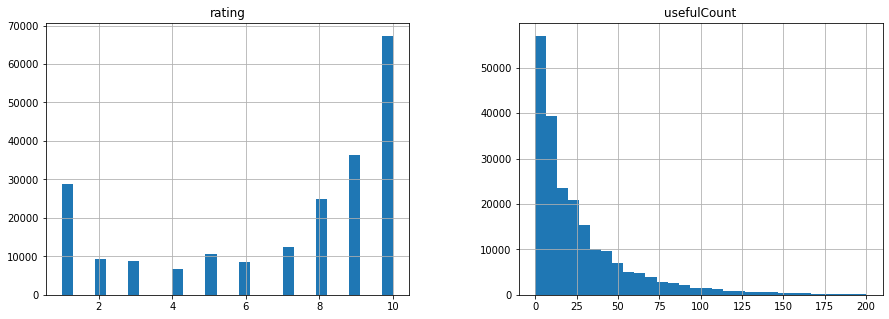

In [58]:
data.hist(bins=30, figsize=(15, 5))

### Word Cloud 

In [62]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wordcloud2 = WordCloud().generate(' '.join(data['review']).lower())

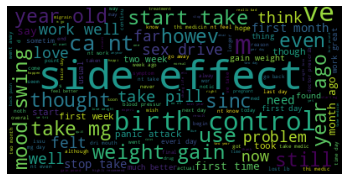

In [63]:
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

In [64]:
text = " ".join(data['review'])

In [65]:
text_dictionary = wordcloud2.process_text(text)
word_freq={k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}

### Sentiment Score using TextBlob

In [66]:
for i, line in data.iterrows():
    feedback = line.values[2]
    blob = TextBlob(feedback)
    data.loc[i,"blob"]  = blob.sentiment[0]

<AxesSubplot:title={'center':'Average sentiment per rating'}, xlabel='rating'>

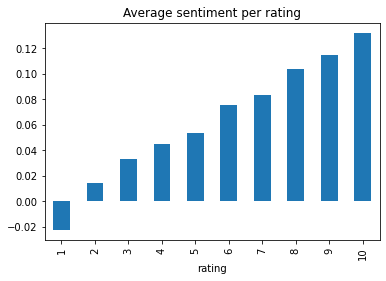

In [67]:
reviews_blob = data.groupby(by = "rating").blob.mean()
reviews_blob.plot(kind = "bar", y = "mean", legend = False, title = "Average sentiment per rating using TextBlob")

## Sentiment Score using NLTK

In [68]:
for i, line in data.iterrows():
    feedback = line.values[2]
    sia = SentimentIntensityAnalyzer()
    data.loc[i,"Positive"]  = sia.polarity_scores(feedback)["pos"]
    data.loc[i,"Negative"]  = sia.polarity_scores(feedback)["neg"]
    data.loc[i,"compound"]  = sia.polarity_scores(feedback)["compound"]
    ####data.loc[i,"neu"]  = sia.polarity_scores(feedback)["compound"]  

<AxesSubplot:title={'center':'Average sentiment per rating'}, xlabel='rating'>

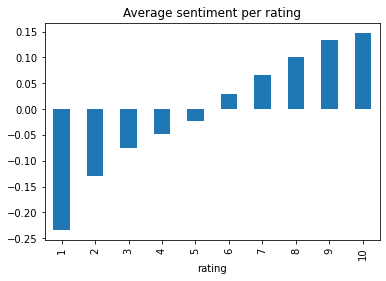

In [69]:
reviews = data.groupby(by = "rating").compound.mean() 
reviews.plot(kind = "bar", y = "mean", legend = False, title = "Average sentiment per rating using NLTK")

### Correlation Matrix

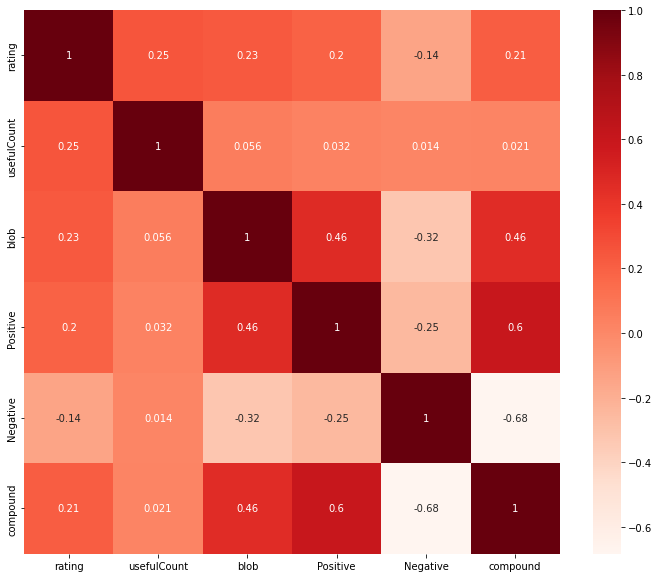

In [70]:
plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [71]:
data.to_csv('clean_drug_review.csv')

In [72]:
## clean_drug_review = pd.read_csv("clean_drug_review.csv", index_col = "uniqueID") #, low_memory=False, nrows=100

In [73]:
# find the 10 most frequent words 
#from nltk.probability import FreqDist
#fdist = FreqDist(token)
#fdist
#fdist.most_common(10)

## Change Rating to positive (1), Negative (-1), and neutral (0)

In [74]:
# Save the final clean dataset  
Clean_Data = data.copy()

# Replace the ratings to positive, negative, and neutral
data["rating"] = np.where(data["rating"]<4, -1 , data["rating"])


In [75]:
data["rating"] = np.where(((data["rating"]>=4) &(data["rating"]<7)) , 0 , data["rating"])

In [76]:
data["rating"] = np.where(data["rating"]>=7, 1 , data["rating"])


In [77]:
data["rating"].unique()

array([ 1,  0, -1])

## TF-IDF  

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.feature_extraction.text import CountVectorizer
vectorizer = TfidfVectorizer(max_features= 3000, min_df = 2)
vectors = vectorizer.fit_transform(data['review'])
feature_names = vectorizer.get_feature_names_out()
dense = vectors.todense()
denselist = dense.tolist()
x = pd.DataFrame(denselist, columns = feature_names)

In [79]:
x

,abdomen,abdomin,abil,abilifi,abl,ablat,abnorm,abort,about,abreva,...,zofran,zoloft,zolpidem,zombi,zomig,zone,zubsolv,zyban,zyprexa,zyrtec
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
213702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.124078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
213703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
213704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
x.to_csv('tfidf_drug_review.csv')

In [ ]:
## x = pd.read_csv("tfidf_drug_review.csv", index_col = "uniqueID") #, low_memory=False, nrows=100

## Modeling

In [81]:
y = data["rating"].to_numpy()

In [82]:
len(y)

213706

In [83]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y)

In [84]:
xtrain.shape

(160279, 3000)

In [85]:
ytrain.shape

(160279,)

In [86]:
def model_metrics(test, pred):
    mse = mean_squared_error(test, pred)
    rmse = np.sqrt(mean_squared_error(test, pred))
    acc = metrics.accuracy_score(test, pred)
    print ("             Mean Squared Error:", mse)
    print ("        Root Mean Squared Error:", rmse)
    print ('          Accuracy of the model:', acc )


### Naive Bayes 

In [101]:
MNB_model = MultinomialNB()
result = MNB_model.fit(xtrain, ytrain)
y_pred_MultinomialNB = MNB_model.predict(xtest)
model_metrics(ytest, y_pred_MultinomialNB)

             Mean Squared Error: 0.7902371460123159
        Root Mean Squared Error: 0.8889528367761227
          Accuracy of the model: 0.7116439253560933


### Logistic Regression 

In [102]:
logreg = LogisticRegression()
logreg.fit(xtrain, ytrain)
y_pred_LR = logreg.predict(xtest)
model_metrics(ytest, y_pred_LR)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


             Mean Squared Error: 0.5413180601568496
        Root Mean Squared Error: 0.7357432025896329
          Accuracy of the model: 0.7694798510116607


### KNN

In [106]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(xtrain, ytrain)
y_pred_knn = knn.predict(xtest)
model_metrics(ytest, y_pred_knn)

             Mean Squared Error: 0.38430007299679936
        Root Mean Squared Error: 0.6199194084691972
          Accuracy of the model: 0.863720590712561


In [104]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(xtrain, ytrain)
y_pred_knn2 = knn.predict(xtest)
model_metrics(ytest, y_pred_knn)

             Mean Squared Error: 1.0018529956763433
        Root Mean Squared Error: 1.0009260690362418
          Accuracy of the model: 0.7038576000898422


In [105]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(xtrain, ytrain)
y_pred_knn3 = knn.predict(xtest)
model_metrics(ytest, y_pred_knn)

             Mean Squared Error: 1.0848073071667883
        Root Mean Squared Error: 1.041540833173039
          Accuracy of the model: 0.6349411346323021


In [ ]:
#k_values = range(6,20)
#scores = []
## look for best N
#for k in k_values:
#    knn = KNeighborsClassifier(n_neighbors=k)
#    knn.fit(xtrain, ytrain)
#    y_pred = knn.predict(xtest)
#    scores.append(metrics.accuracy_score(ytest, y_pred))
#
#print(scores)

In [ ]:
## allow plots to appear within the notebook
#%matplotlib inline
## plot the relationship between K and testing accuracy
## plt.plot(x_axis, y_axis)
#plt.plot(k_values, scores)
#plt.xlabel('Value of K for KNN')
#plt.ylabel('Testing Accuracy')

### Decision Tree

In [89]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(xtrain,ytrain)
y_pred_dt=decision_tree.predict(xtest)
model_metrics(ytest, y_pred_dt)

             Mean Squared Error: 0.38214760327175396
        Root Mean Squared Error: 0.6181808823247076
          Accuracy of the model: 0.8463885301439347


### Random Forest

In [88]:
#kfold = model_selection.KFold(n_splits=10, random_state=seed)
random_forest = RandomForestClassifier(n_estimators=100, max_features=100)
random_forest.fit(xtrain, ytrain)
y_pred_rf = random_forest.predict(xtest)
model_metrics(ytest, y_pred_rf)
#results = model_selection.cross_val_score(model, X, Y, cv=kfold)
#print(results.mean())

             Mean Squared Error: 0.27881033934153143
        Root Mean Squared Error: 0.5280249419691568
          Accuracy of the model: 0.8936305613266701


### XGBoost 

In [90]:
xgb_model = XGBClassifier(random_state = 0 )
xgb_model.fit(xtrain, ytrain)
y_pred_xgb = xgb_model.predict(xtest)
model_metrics(ytest, y_pred_xgb)

/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12:11:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
             Mean Squared Error: 0.572032867276845
        Root Mean Squared Error: 0.7563285445339512
          Accuracy of the model: 0.769592153779924


In [99]:
len(Max_Vot_pred)

53426

### Max Voting

In [100]:
Max_Vot_pred = np.array([])
for i in range(0,len(xtest)):
    Max_Vot_pred = np.append(Max_Vot_pred, stats.mode([y_pred_xgb[i], y_pred_dt[i], y_pred_rf[i]]).mode)
    
model_metrics(ytest, Max_Vot_pred)

             Mean Squared Error: 0.26192748984595804
        Root Mean Squared Error: 0.511788520627376
          Accuracy of the model: 0.8978231980084975


In [160]:
Max_Vot_pred = np.array([])
for i in range(0,len(xtest)):
    Max_Vot_pred = np.append(Max_Vot_pred, stats.mode([y_pred_LR[i], y_pred_dt[i], y_pred_knn[i]]).mode)
    
model_metrics(ytest, Max_Vot_pred)

             Mean Squared Error: 0.27188500196529847
        Root Mean Squared Error: 0.5214259314277517
          Accuracy of the model: 0.8946038519849514


## Model Evaluation

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
   
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(train_features, train_labels)
base_accuracy = evaluate(base_model, test_features, test_labels)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, test_features, test_labels)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


## Model Evaluation 

In [150]:
def model_evaluation(predicted_y):
    confusion = confusion_matrix(ytest, predicted_y)
    print('Confusion Matrix\n')
    print(confusion)

    #importing accuracy_score, precision_score, recall_score, f1_score
    print('\nAccuracy: {:.2f}\n'.format(accuracy_score(ytest, predicted_y)))

    print('Micro Precision: {:.2f}'.format(precision_score(ytest, predicted_y, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(ytest, predicted_y, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(ytest, predicted_y, average='micro')))

    print('Macro Precision: {:.2f}'.format(precision_score(ytest, predicted_y, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(ytest, predicted_y, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(ytest, predicted_y, average='macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(ytest, predicted_y, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(ytest, predicted_y, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(ytest, predicted_y, average='weighted')))

    print('\nClassification Report\n')
    print(classification_report(ytest, predicted_y, target_names=['negative', 'neutral', 'positive']))
    

### Naive Bayes

In [152]:
model_evaluation(y_pred_MultinomialNB)

Confusion Matrix

[[ 3077     3  8589]
 [  471     9  5987]
 [  349     7 34935]]

Accuracy: 0.71

Micro Precision: 0.71
Micro Recall: 0.71
Micro F1-score: 0.71

Macro Precision: 0.66
Macro Recall: 0.42
Macro F1-score: 0.41

Weighted Precision: 0.70
Weighted Recall: 0.71
Weighted F1-score: 0.63

Classification Report

              precision    recall  f1-score   support

    negative       0.79      0.26      0.40     11669
     neutral       0.47      0.00      0.00      6467
    positive       0.71      0.99      0.82     35291

    accuracy                           0.71     53427
   macro avg       0.66      0.42      0.41     53427
weighted avg       0.70      0.71      0.63     53427



### Logistic Regression

In [153]:
model_evaluation(y_pred_LR)

Confusion Matrix

[[ 7530   423  3716]
 [ 1734   688  4045]
 [ 1819   579 32893]]

Accuracy: 0.77

Micro Precision: 0.77
Micro Recall: 0.77
Micro F1-score: 0.77

Macro Precision: 0.63
Macro Recall: 0.56
Macro F1-score: 0.57

Weighted Precision: 0.73
Weighted Recall: 0.77
Weighted F1-score: 0.74

Classification Report

              precision    recall  f1-score   support

    negative       0.68      0.65      0.66     11669
     neutral       0.41      0.11      0.17      6467
    positive       0.81      0.93      0.87     35291

    accuracy                           0.77     53427
   macro avg       0.63      0.56      0.57     53427
weighted avg       0.73      0.77      0.74     53427



### KNN with K= 1

In [154]:
model_evaluation(y_pred_knn)

Confusion Matrix

[[ 7442    93  4134]
 [   91  3899  2477]
 [  283   203 34805]]

Accuracy: 0.86

Micro Precision: 0.86
Micro Recall: 0.86
Micro F1-score: 0.86

Macro Precision: 0.91
Macro Recall: 0.74
Macro F1-score: 0.80

Weighted Precision: 0.88
Weighted Recall: 0.86
Weighted F1-score: 0.85

Classification Report

              precision    recall  f1-score   support

    negative       0.95      0.64      0.76     11669
     neutral       0.93      0.60      0.73      6467
    positive       0.84      0.99      0.91     35291

    accuracy                           0.86     53427
   macro avg       0.91      0.74      0.80     53427
weighted avg       0.88      0.86      0.85     53427



### Decision Tree

In [155]:
model_evaluation(y_pred_dt)

Confusion Matrix

[[ 9094   592  1983]
 [  719  4228  1520]
 [ 2087  1306 31898]]

Accuracy: 0.85

Micro Precision: 0.85
Micro Recall: 0.85
Micro F1-score: 0.85

Macro Precision: 0.79
Macro Recall: 0.78
Macro F1-score: 0.78

Weighted Precision: 0.85
Weighted Recall: 0.85
Weighted F1-score: 0.85

Classification Report

              precision    recall  f1-score   support

    negative       0.76      0.78      0.77     11669
     neutral       0.69      0.65      0.67      6467
    positive       0.90      0.90      0.90     35291

    accuracy                           0.85     53427
   macro avg       0.79      0.78      0.78     53427
weighted avg       0.85      0.85      0.85     53427



### Random Forest

In [156]:
model_evaluation(y_pred_rf)

Confusion Matrix

[[ 8989     1  2679]
 [  357  3864  2246]
 [  392     8 34891]]

Accuracy: 0.89

Micro Precision: 0.89
Micro Recall: 0.89
Micro F1-score: 0.89

Macro Precision: 0.93
Macro Recall: 0.79
Macro F1-score: 0.84

Weighted Precision: 0.90
Weighted Recall: 0.89
Weighted F1-score: 0.89

Classification Report

              precision    recall  f1-score   support

    negative       0.92      0.77      0.84     11669
     neutral       1.00      0.60      0.75      6467
    positive       0.88      0.99      0.93     35291

    accuracy                           0.89     53427
   macro avg       0.93      0.79      0.84     53427
weighted avg       0.90      0.89      0.89     53427



### XGBoost

In [157]:
model_evaluation(y_pred_xgb)

Confusion Matrix

[[ 6390   160  5119]
 [ 1191   565  4711]
 [  965   164 34162]]

Accuracy: 0.77

Micro Precision: 0.77
Micro Recall: 0.77
Micro F1-score: 0.77

Macro Precision: 0.72
Macro Recall: 0.53
Macro F1-score: 0.55

Weighted Precision: 0.75
Weighted Recall: 0.77
Weighted F1-score: 0.73

Classification Report

              precision    recall  f1-score   support

    negative       0.75      0.55      0.63     11669
     neutral       0.64      0.09      0.15      6467
    positive       0.78      0.97      0.86     35291

    accuracy                           0.77     53427
   macro avg       0.72      0.53      0.55     53427
weighted avg       0.75      0.77      0.73     53427



### Max Voting 

In [161]:
model_evaluation(Max_Vot_pred)

Confusion Matrix

[[ 9204    44  2421]
 [  525  3910  2032]
 [  544    65 34682]]

Accuracy: 0.89

Micro Precision: 0.89
Micro Recall: 0.89
Micro F1-score: 0.89

Macro Precision: 0.92
Macro Recall: 0.79
Macro F1-score: 0.84

Weighted Precision: 0.90
Weighted Recall: 0.89
Weighted F1-score: 0.89

Classification Report

              precision    recall  f1-score   support

    negative       0.90      0.79      0.84     11669
     neutral       0.97      0.60      0.75      6467
    positive       0.89      0.98      0.93     35291

    accuracy                           0.89     53427
   macro avg       0.92      0.79      0.84     53427
weighted avg       0.90      0.89      0.89     53427



In [ ]:
model_evaluation(Max_Vot_pred)

# The End 